# Tau PT Regression + JetID Classification Merge

In this notebook we will implement a NN that merges the regression and classification NN that we developed for pT regression and jetID, respectively.

In [27]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot



from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv1D
from qkeras.utils import load_qmodel

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/merged_pt_regress_jet_ID.h5'

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [28]:
import random

seed = 1111
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

def create_train_test_data(dir_path, test_index=400000, train = True):
        
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
    selection_bkg = reco_pt_bkg > 11.5
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 11
    y_qcd_pT = truth_pt_qcd[selection_qcd]
        
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    
    print(y_sig, y_bkg, y_qcd)
    
    if train:
        X_bkg = list(X_bkg)
        y_bkg = list(y_bkg)
        y_bkg_pT = list(y_bkg_pT)
        percent = 0.64
        for _ in range(int(percent*len(X_bkg))):
            n = len(X_bkg)
            random_ind = random.randint(0, n - 1)
            del X_bkg[random_ind]
            del y_bkg[random_ind]
            del y_bkg_pT[random_ind]
        X_bkg = np.asarray(X_bkg)
        y_bkg = np.asarray(y_bkg)
        y_bkg_pT = np.asarray(y_bkg_pT)
        
        X_qcd = list(X_qcd)
        y_qcd = list(y_qcd)
        y_qcd_pT = list(y_qcd_pT)
        for _ in range(int(percent*len(X_qcd))):
            n = len(X_qcd)
            random_ind = random.randint(0, n - 1)
            del X_qcd[random_ind]
            del y_qcd[random_ind]
            del y_qcd_pT[random_ind]
        X_qcd = np.asarray(X_qcd)
        y_qcd = np.asarray(y_qcd)
        y_qcd_pT = np.asarray(y_qcd_pT)

    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    MinBias_pT_1 = [1 for i in y_bkg_pT]
    qcd_pT_1 = [1 for i in y_qcd_pT]
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+9] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    return X_train, y_train_jetID, y_train_pT

X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
X_train = X_train_jetID
y_train = y_train_pT_regress
X_test = X_test_jetID
y_test = y_test_pT_regress

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


In [29]:
print(len(X_train_jetID))
print(len(y_train_jetID))
print(len(y_train_pT_regress))
print(X_train_jetID)
print(y_train_jetID)
print(y_train_pT_regress)

211633
211633
211633
[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 3.9000e+01 -7.8125e-02 -3.1250e-02 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [ 1.4000e+01  0.0000e+00 -1.5625e-02 ...  0.0000e+00  0.0000e+00
   1.0000e+00]
 [ 2.4250e+01  1.5625e-02  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
[1. 1. 1. ... 0. 0. 0.]
[0.98325592 1.86459839 0.84331274 ... 1.         1.         1.        ]


## Model

In [30]:
from keras.layers import *
from qkeras import *
# Merged Model Architecture

#import tensorflow_model_optimization as tfmot

# more nodes per layer, # of nodes < 100, # of layers < 10
# don't want to stack big layers --> one tiny layer (rather, scale down slowly)

def merged_model():

    inputs = tf.keras.layers.Input(shape=(80,), name='model_input')
    
    main_branch = tf.keras.layers.Dense(25, activation = "ReLU", name='Dense1')(inputs)
    main_branch = tf.keras.layers.Dense(25, activation = "ReLU", name='Dense2')(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "ReLU", name='Dense3')(main_branch)
    main_branch = tf.keras.layers.Dense(15, activation = "ReLU", name='Dense4')(main_branch)
    main_branch = tf.keras.layers.Dense(10, activation = "ReLU", name='Dense5')(main_branch)

    jetID_branch = tf.keras.layers.Dense(1, activation='sigmoid', name='jetID_output')(main_branch)

    pT_branch = tf.keras.layers.Dense(1, name='pT_output')(main_branch)

    model = tf.keras.Model(inputs = inputs, outputs = [jetID_branch, pT_branch])
    
    return model

#####------------------ MODEL TRAINING ------------------#####
bits = 9
bits_int = 2
alpha_val = 1
bits_conv = 9


def quantize_merge():
    model = tf.keras.Sequential()
    
    inputs = tf.keras.layers.Input(shape=(80,), name='model_input')
    
    #kernel_initializer = initializers.lecun_uniform(seed)
    
    main_branch = QDense(25, name='Dense_1',
                     kernel_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     bias_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     kernel_initializer='lecun_uniform')(inputs)  # , kernel_regularizer=l1(0.0001)))
    main_branch = QActivation(activation=quantized_relu(bits), name='relu_1')(main_branch)
    main_branch = QDense(25, name='Dense_2',
                     kernel_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     bias_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     kernel_initializer='lecun_uniform')(main_branch)
    main_branch = QActivation(activation=quantized_relu(bits), name='relu_2')(main_branch)
    main_branch = QDense(15, name='Dense_3',
                     kernel_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     bias_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     kernel_initializer='lecun_uniform')(main_branch)  # , kernel_regularizer=l1(0.0001)))
    main_branch = QActivation(activation=quantized_relu(bits), name='relu_3')(main_branch)
    main_branch = QDense(15, name='Dense_4',
                     kernel_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     bias_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     kernel_initializer='lecun_uniform')(main_branch)
    main_branch = QActivation(activation=quantized_relu(bits), name='relu_4')(main_branch)
    main_branch = QDense(10, name='Dense_5',
                     kernel_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     bias_quantizer=quantized_bits(
                         bits, bits_int, alpha=alpha_val),
                     kernel_initializer='lecun_uniform')(main_branch)
    main_branch = QActivation(activation=quantized_relu(bits), name='relu_5')(main_branch)
    jetID_branch = QDense(1, name='Dense_6',
                     kernel_quantizer=quantized_bits(
                         16, 6, alpha=alpha_val),
                     bias_quantizer=quantized_bits(
                         16, 6, alpha=alpha_val),
                     kernel_initializer='lecun_uniform')(main_branch)
    jetID_branch = tf.keras.layers.Activation(activation='sigmoid', name='jetID_output')(jetID_branch)
    
    pT_branch = QDense(1, name='pT_output',
                     kernel_quantizer=quantized_bits(
                         16, 6, alpha=alpha_val),
                     bias_quantizer=quantized_bits(
                         16, 6, alpha=alpha_val),
                     kernel_initializer='lecun_uniform')(main_branch)
    

    #model.compile(loss='binary_crossentropy', optimizer='adam',
    #              metrics=['binary_accuracy'])

    model = tf.keras.Model(inputs = inputs, outputs = [jetID_branch, pT_branch])

    
    return model
    

## Pruning

In [38]:
X_train = X_train_jetID

batch_size = 256
epochs = 20
validation_split = 0.2 # 20% of training set will be used for validation set. 

# sparsity parameters
i_sparsity = 0 # initial 
f_sparsity = 0.6 # final

num_samples = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_samples / batch_size).astype(np.int32) * epochs
def fit_batch(gamma_values):
    trained_models = list()
    for gamma in gamma_values:
        model = quantize_merge()
        print('Training model for gamma equal to ', gamma)
        # Define model for pruning.
        pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=i_sparsity,
                                                                       final_sparsity=f_sparsity,
                                                                       begin_step=0,
                                                                       end_step=end_step)
        }

        prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
        model_for_pruning = prune_low_magnitude(model, **pruning_params)

        # `prune_low_magnitude` requires a recompile.
        model_for_pruning.compile(optimizer='adam',
                      loss={'prune_low_magnitude_jetID_output': 'binary_crossentropy', 
                        'prune_low_magnitude_pT_output': 'mean_squared_error'},
                      loss_weights={'prune_low_magnitude_jetID_output': gamma, 
                                'prune_low_magnitude_pT_output': 1 - gamma},
                      metrics=['accuracy'])

        model_for_pruning.summary()

        #logdir = tempfile.mkdtemp()

        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
          #tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=2, patience=5)
        ]

        model_for_pruning.fit({'model_input': X_train},
                            {'prune_low_magnitude_jetID_output': y_train_jetID, 'prune_low_magnitude_pT_output': y_train_pT_regress},
                            epochs=20, batch_size=256, verbose=2, validation_split=0.20, callbacks = [callbacks])
        model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

        trained_models.append(model_for_export)
    return trained_models

In [39]:
gammas = [0.3, 0.6, 0.65, 0.7]
trained_models = fit_batch(gammas)

Training model for gamma equal to  0.3
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_input (InputLayer)       [(None, 80)]         0           []                               
                                                                                                  
 prune_low_magnitude_Dense_1 (P  (None, 25)          4027        ['model_input[0][0]']            
 runeLowMagnitude)                                                                                
                                                                                                  
 prune_low_magnitude_relu_1 (Pr  (None, 25)          1           ['prune_low_magnitude_Dense_1[0][
 uneLowMagnitude)                                                0]']                             
                                                    

Epoch 9/20
662/662 - 1s - loss: 0.2178 - prune_low_magnitude_jetID_output_loss: 0.3627 - prune_low_magnitude_pT_output_loss: 0.1558 - prune_low_magnitude_jetID_output_accuracy: 0.8400 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.1483 - val_prune_low_magnitude_jetID_output_loss: 0.4006 - val_prune_low_magnitude_pT_output_loss: 0.0402 - val_prune_low_magnitude_jetID_output_accuracy: 0.8317 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 10/20
662/662 - 1s - loss: 0.2206 - prune_low_magnitude_jetID_output_loss: 0.3676 - prune_low_magnitude_pT_output_loss: 0.1576 - prune_low_magnitude_jetID_output_accuracy: 0.8366 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.1405 - val_prune_low_magnitude_jetID_output_loss: 0.3978 - val_prune_low_magnitude_pT_output_loss: 0.0302 - val_prune_low_magnitude_jetID_output_accuracy: 0.8413 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 11/20
662/662 - 1s - loss

 runeLowMagnitude)                                               ]']                              
                                                                                                  
 prune_low_magnitude_relu_4 (Pr  (None, 15)          1           ['prune_low_magnitude_Dense_4[0][
 uneLowMagnitude)                                                0]']                             
                                                                                                  
 prune_low_magnitude_Dense_5 (P  (None, 10)          312         ['prune_low_magnitude_relu_4[0][0
 runeLowMagnitude)                                               ]']                              
                                                                                                  
 prune_low_magnitude_relu_5 (Pr  (None, 10)          1           ['prune_low_magnitude_Dense_5[0][
 uneLowMagnitude)                                                0]']                             
          

Epoch 14/20
662/662 - 1s - loss: 0.2801 - prune_low_magnitude_jetID_output_loss: 0.3592 - prune_low_magnitude_pT_output_loss: 0.1615 - prune_low_magnitude_jetID_output_accuracy: 0.8416 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.2587 - val_prune_low_magnitude_jetID_output_loss: 0.4125 - val_prune_low_magnitude_pT_output_loss: 0.0279 - val_prune_low_magnitude_jetID_output_accuracy: 0.8330 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 15/20
662/662 - 1s - loss: 0.2779 - prune_low_magnitude_jetID_output_loss: 0.3565 - prune_low_magnitude_pT_output_loss: 0.1599 - prune_low_magnitude_jetID_output_accuracy: 0.8431 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.2502 - val_prune_low_magnitude_jetID_output_loss: 0.3954 - val_prune_low_magnitude_pT_output_loss: 0.0323 - val_prune_low_magnitude_jetID_output_accuracy: 0.8399 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 16/20
662/662 - 1s - los

Epoch 2/20
662/662 - 1s - loss: 0.3310 - prune_low_magnitude_jetID_output_loss: 0.4006 - prune_low_magnitude_pT_output_loss: 0.2017 - prune_low_magnitude_jetID_output_accuracy: 0.8351 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.3000 - val_prune_low_magnitude_jetID_output_loss: 0.4557 - val_prune_low_magnitude_pT_output_loss: 0.0108 - val_prune_low_magnitude_jetID_output_accuracy: 0.8010 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 3/20
662/662 - 1s - loss: 0.3159 - prune_low_magnitude_jetID_output_loss: 0.3782 - prune_low_magnitude_pT_output_loss: 0.2003 - prune_low_magnitude_jetID_output_accuracy: 0.8380 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.3246 - val_prune_low_magnitude_jetID_output_loss: 0.4939 - val_prune_low_magnitude_pT_output_loss: 0.0101 - val_prune_low_magnitude_jetID_output_accuracy: 0.7799 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 4/20
662/662 - 1s - loss: 

Epoch 19/20
662/662 - 1s - loss: 0.2837 - prune_low_magnitude_jetID_output_loss: 0.3502 - prune_low_magnitude_pT_output_loss: 0.1604 - prune_low_magnitude_jetID_output_accuracy: 0.8441 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.2926 - val_prune_low_magnitude_jetID_output_loss: 0.4314 - val_prune_low_magnitude_pT_output_loss: 0.0350 - val_prune_low_magnitude_jetID_output_accuracy: 0.8159 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 20/20
662/662 - 1s - loss: 0.2832 - prune_low_magnitude_jetID_output_loss: 0.3497 - prune_low_magnitude_pT_output_loss: 0.1596 - prune_low_magnitude_jetID_output_accuracy: 0.8442 - prune_low_magnitude_pT_output_accuracy: 0.3900 - val_loss: 0.2226 - val_prune_low_magnitude_jetID_output_loss: 0.3256 - val_prune_low_magnitude_pT_output_loss: 0.0313 - val_prune_low_magnitude_jetID_output_accuracy: 0.8633 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Training model for gamma equal

Epoch 7/20
662/662 - 1s - loss: 0.3107 - prune_low_magnitude_jetID_output_loss: 0.3733 - prune_low_magnitude_pT_output_loss: 0.1645 - prune_low_magnitude_jetID_output_accuracy: 0.8313 - prune_low_magnitude_pT_output_accuracy: 0.3899 - val_loss: 0.2860 - val_prune_low_magnitude_jetID_output_loss: 0.3948 - val_prune_low_magnitude_pT_output_loss: 0.0323 - val_prune_low_magnitude_jetID_output_accuracy: 0.8390 - val_prune_low_magnitude_pT_output_accuracy: 0.9999 - 1s/epoch - 2ms/step
Epoch 8/20
662/662 - 1s - loss: 0.3126 - prune_low_magnitude_jetID_output_loss: 0.3754 - prune_low_magnitude_pT_output_loss: 0.1659 - prune_low_magnitude_jetID_output_accuracy: 0.8341 - prune_low_magnitude_pT_output_accuracy: 0.3899 - val_loss: 0.3039 - val_prune_low_magnitude_jetID_output_loss: 0.4203 - val_prune_low_magnitude_pT_output_loss: 0.0324 - val_prune_low_magnitude_jetID_output_accuracy: 0.8318 - val_prune_low_magnitude_pT_output_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 9/20
662/662 - 1s - loss: 

In [66]:
#trained_models[0].save("../models/testprunestrip.h5")

In [9]:
#bob = load_qmodel("../models/testprunestrip.h5")

In [220]:
# Coupling Loss Functions

def compile_model(model, gamma):
    opt = optimizers.Adam()
    model.compile(optimizer=opt,
                  loss={'jetID_output': 'binary_crossentropy', 
                        'pT_output': 'mean_squared_error'},
                  loss_weights={'jetID_output': gamma, 
                                'pT_output': 1 - gamma}, 
                  metrics=['accuracy'])
        
    return model


import time
X_train = X_train_jetID

# FIT BATCH OF MODELS

def fit_batch(gamma_values):
    
    history = list()
    trained_models = list()
    
    print('Starting training on batch of models for gamma values ', gamma_values, '\n\n')
    
    for gamma in gamma_values:
        callback = tf.keras.callbacks.EarlyStopping(verbose = 1, patience=5)
        print('Training model for gamma equal to ', gamma)
        #quantize_annotate_layer = tfmo.quantization.keras.quantize_annotate_layer
        model = quantize_merge()
        # Quantize the entire model.
        #model = tfmot.quantization.keras.quantize_model(model)
        model = compile_model(model, gamma)
        model.summary()
        
        start = time.time()
        model_history = model.fit({'model_input': X_train},
                            {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
                            epochs=20, batch_size=256, verbose=2, validation_split=0.20, callbacks = [callback])
        print(f'Training time: {time.time() - start}\n')
        history.append(model_history)
        trained_models.append(model)
        
    return history, trained_models

In [221]:
gammas = [0.3, 0.6, 0.65, 0.7]
training_history, trained_models = fit_batch(gammas)

Starting training on batch of models for gamma values  [0.3, 0.6, 0.65, 0.7] 


Training model for gamma equal to  0.3
Model: "model_91"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_input (InputLayer)       [(None, 80)]         0           []                               
                                                                                                  
 Dense_1 (QDense)               (None, 25)           2025        ['model_input[0][0]']            
                                                                                                  
 relu_1 (QActivation)           (None, 25)           0           ['Dense_1[0][0]']                
                                                                                                  
 Dense_2 (QDense)               (None, 25)           650         ['relu

                                                                                                  
 Dense_1 (QDense)               (None, 25)           2025        ['model_input[0][0]']            
                                                                                                  
 relu_1 (QActivation)           (None, 25)           0           ['Dense_1[0][0]']                
                                                                                                  
 Dense_2 (QDense)               (None, 25)           650         ['relu_1[0][0]']                 
                                                                                                  
 relu_2 (QActivation)           (None, 25)           0           ['Dense_2[0][0]']                
                                                                                                  
 Dense_3 (QDense)               (None, 15)           390         ['relu_2[0][0]']                 
          

                                                                                                  
 relu_2 (QActivation)           (None, 25)           0           ['Dense_2[0][0]']                
                                                                                                  
 Dense_3 (QDense)               (None, 15)           390         ['relu_2[0][0]']                 
                                                                                                  
 relu_3 (QActivation)           (None, 15)           0           ['Dense_3[0][0]']                
                                                                                                  
 Dense_4 (QDense)               (None, 15)           240         ['relu_3[0][0]']                 
                                                                                                  
 relu_4 (QActivation)           (None, 15)           0           ['Dense_4[0][0]']                
          

 Dense_2 (QDense)               (None, 25)           650         ['relu_1[0][0]']                 
                                                                                                  
 relu_2 (QActivation)           (None, 25)           0           ['Dense_2[0][0]']                
                                                                                                  
 Dense_3 (QDense)               (None, 15)           390         ['relu_2[0][0]']                 
                                                                                                  
 relu_3 (QActivation)           (None, 15)           0           ['Dense_3[0][0]']                
                                                                                                  
 Dense_4 (QDense)               (None, 15)           240         ['relu_3[0][0]']                 
                                                                                                  
 relu_4 (Q

In [142]:
# model = compile_model(model, 0.33333)
# model.summary()
# #Train the network
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)
# X_train = X_train_jetID
# history = model.fit({'input': X_train},
#                             {'jetID_output': y_train_jetID, 'pT_output': y_train_pT_regress},
#                     epochs=20,
#                     batch_size=128,
#                     verbose=2,
#                     validation_split=0.20,
#                     callbacks = [callback])
# model.save("../models/merged_quantized_updated.h5")

### Analyzing Performance

In [33]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5'
model_id = load_model(model_id_name)


In [40]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten() # take the regression output
    print(y_pred)
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    print(pred_pt)
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 2s 718us/step
[1.2712975 1.3093834 0.8722687 ... 1.2255287 1.0829468 1.1755219]
[ 76.59567   50.738605 160.93356  ...  54.84241   78.78438   19.983871]


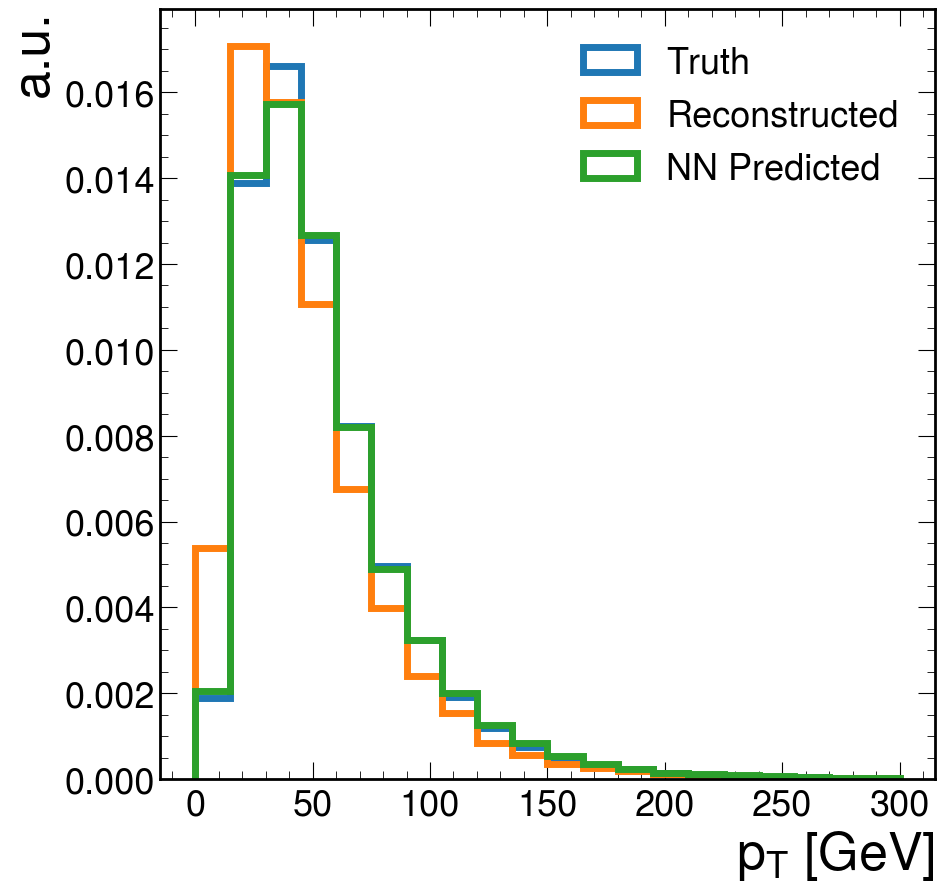

0.3
2043/2043 [==============================] - 2s 755us/step
[1.0718002 1.2335091 1.0135498 ... 1.2167664 0.9950218 1.1639252]
[ 64.575966  47.798477 186.99994  ...  54.450294  72.38784   19.786728]


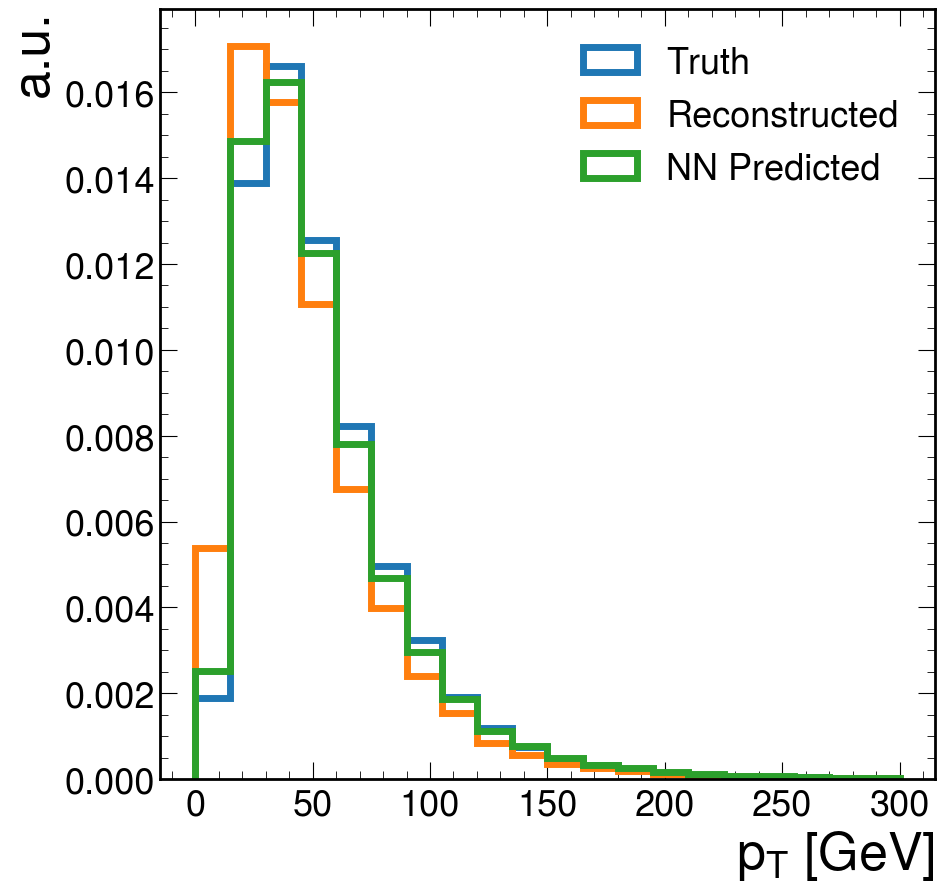

0.6
2043/2043 [==============================] - 2s 709us/step
[1.234932  1.3101883 1.2531509 ... 1.2856445 1.025444  1.214447 ]
[ 74.40465   50.7698   231.20634  ...  57.532593  74.60105   20.6456  ]


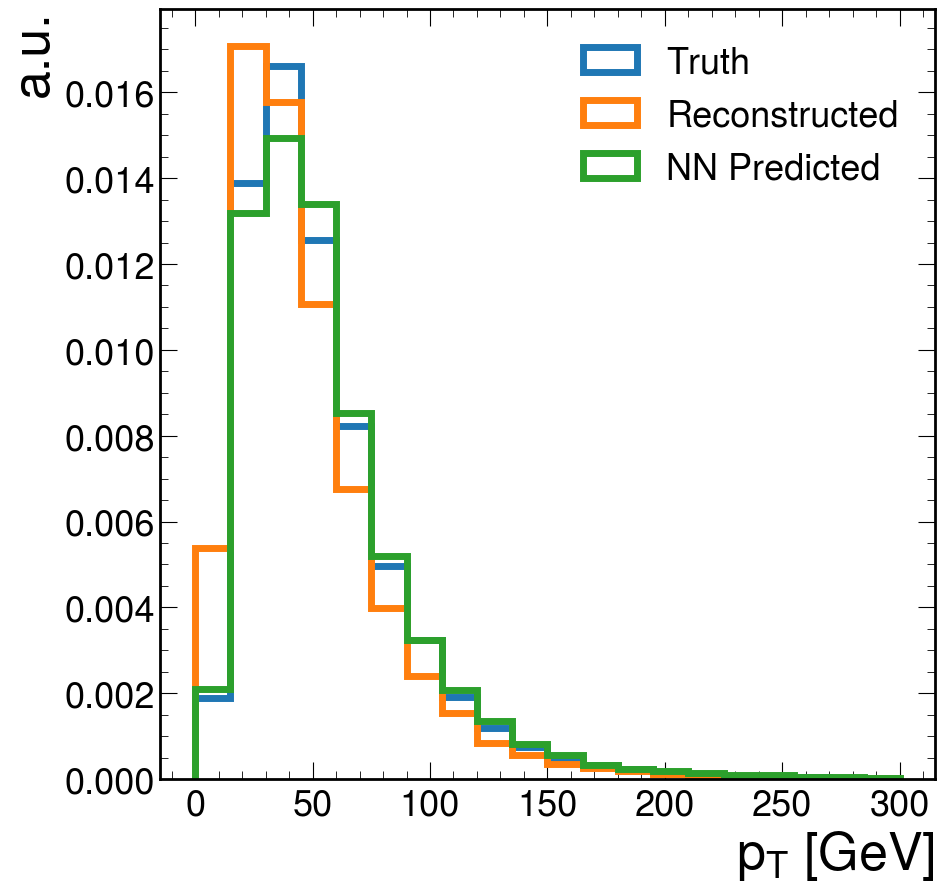

0.65
2043/2043 [==============================] - 2s 744us/step
[1.2182007 1.3646126 1.0744553 ... 1.1978455 1.0895538 1.2746964]
[ 73.39659   52.87874  198.237    ...  53.603584  79.265045  21.669838]


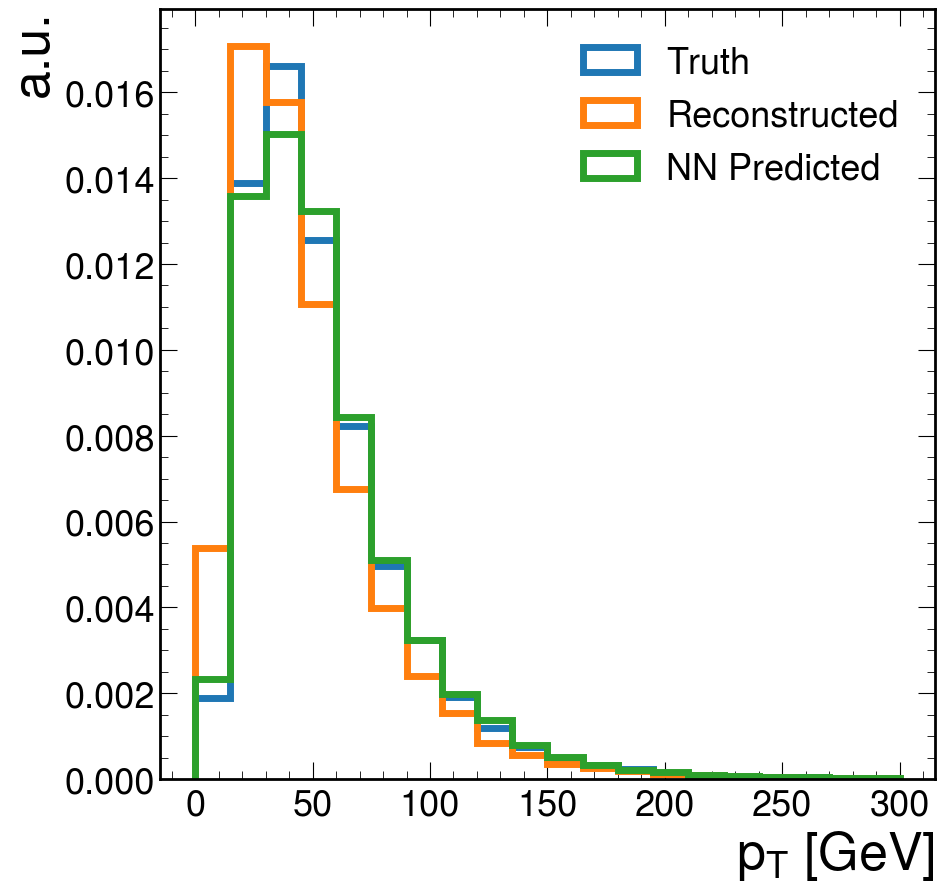

0.7


In [41]:
# load_and_predict_test("../../ntuples/Jan_25_2023", model)
for i in range(len(trained_models)):
    load_and_predict_test("../../ntuples/Jan_25_2023", trained_models[i])
    print(gammas[i])

In [42]:
# pt di

def prep_rate_data(NormalModelID, 
                   ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(NormalModelID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    #model_regress = load_model(ModelNameRegress)
    
    #minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    #minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    #true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    #true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    #sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    #minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    #true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    #minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    
    plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(2):
        if i == 0:
            modelID = load_model("../models/new_merged.h5") # merged
            model_regress = load_model("../models/new_merged.h5")
        elif i == 1:
            modelID = load_qmodel("../models/quantized_merged_new_gamma30.h5") # merged testing
            model_regress = load_qmodel("../models/quantized_merged_new_gamma30.h5")
        #modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
        if i == 0:
            plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Full-bits, $\gamma=0.7$',linewidth=5)
        elif i == 1:
            plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Quantized, $\gamma=0.3$',linewidth=5)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(len(ModelNameID)):
        modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)
        model_regress = ModelNameRegress[i]

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

        plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID, $\gamma=$' + str(round(gammas[i], 1)),linewidth=2)
        hep.cms.text("Phase 2 Simulation")
        hep.cms.lumitext("PU 200 (14 TeV)")

        plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
        plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

        plt.yscale('log')
        #plt.legend(loc='best',fontsize=20)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.show()

    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 727us/step


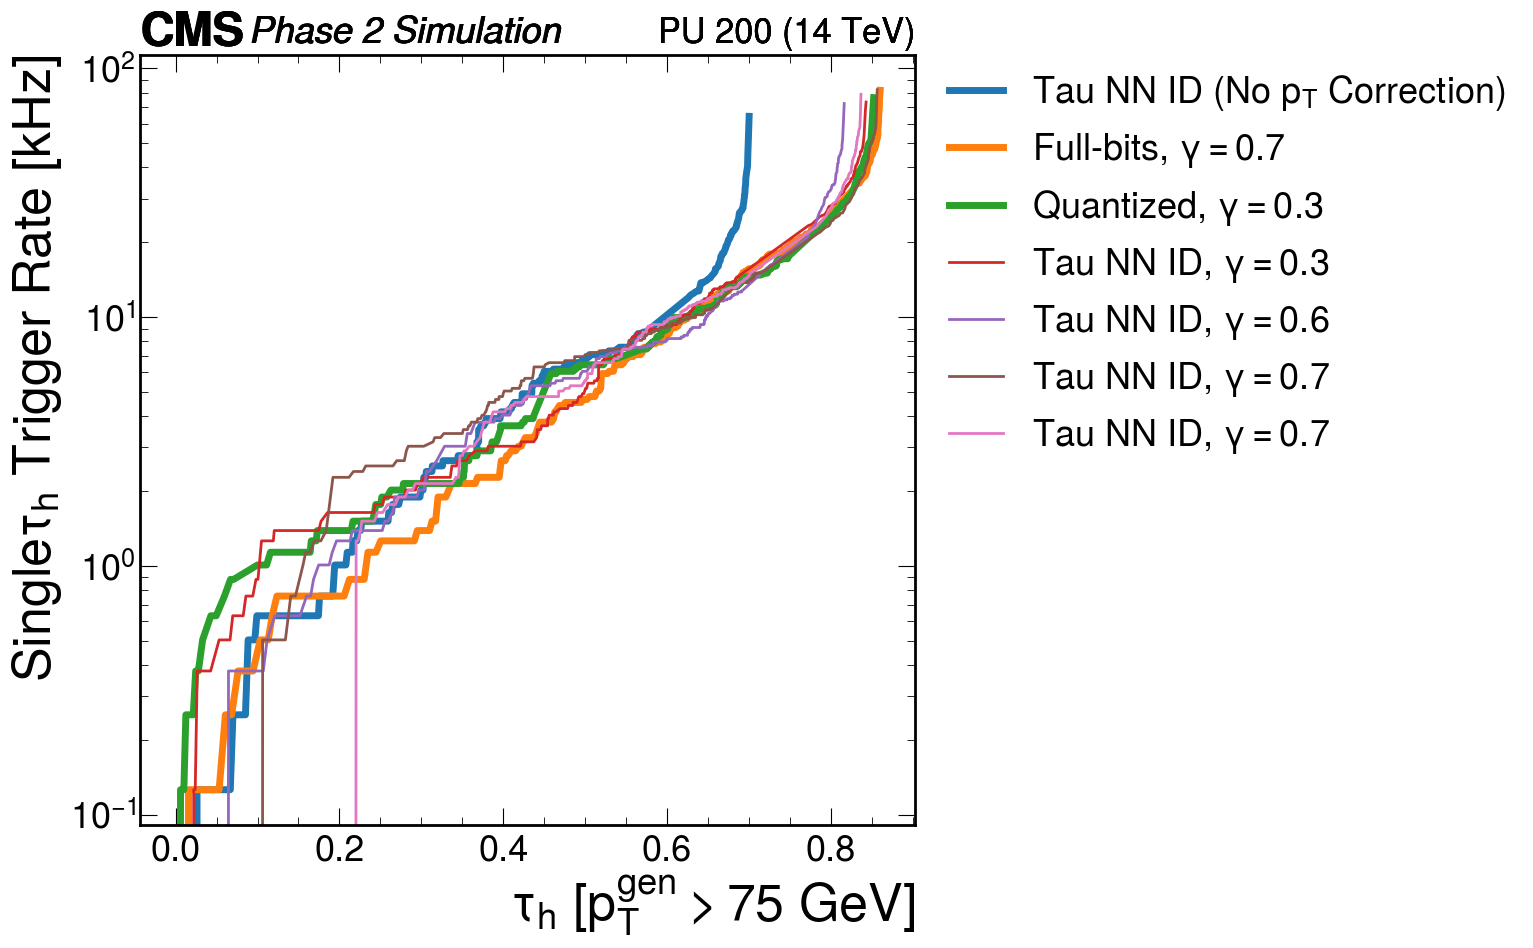

In [43]:
# n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
#                                                                                                                                     trained_models,
#                                                                                                                                     truth_sig_pt_cut=75,
#                                                                                                                                     minbias_pt_cut_value=75)

n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    trained_models,
                                                                                                                                    trained_models,
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)

In [71]:
#trained_models[0].save("../models/quantized_merged_pruned_gamma30.h5")

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

In [15]:
#Load the pts and then plot the actual distributions
model = load_qmodel('../models/quantized_merged_2_gamma44.h5')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test)[1].flatten() # take the regression output
    print(y_pred)
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    print(pred_pt)
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 4s 2ms/step
[1.200552  1.1154041 0.8399601 ... 1.3746452 1.0041504 1.1697254]
[ 72.33326   43.22191  154.97264  ...  61.515373  73.05194   19.885332]


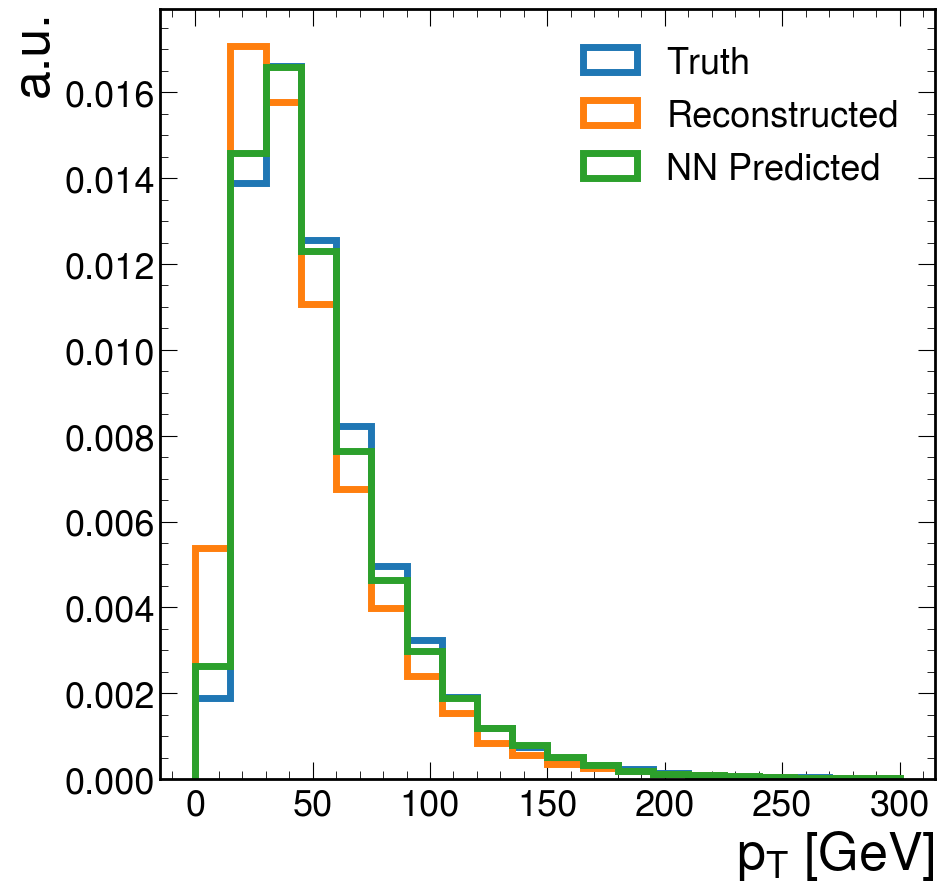

In [17]:
#model = load_model("../models/merged_quantized.h5")
load_and_predict_test("../../ntuples/Jan_25_2023", model)

In [18]:
# Looking nice!! 

In [19]:
#print(trained_models[8]
model = load_qmodel("../models/quantized_merged_1_gamma66.h5")

### Combined ROC Curve

In [20]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5'
model_pt_regress_name = '../models/merged_pt_regress_jet_ID.h5'
model_id = load_model(model_id_name)
#MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
#MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

In [21]:
def prep_rate_data(NormalModelID, 
                   ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(model_id_name)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    model_regress = load_model("../models/pt_regress_v1_bestest.h5")
    
    minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    sig_list_corrected = []
    bkg_list_corrected = []

    for tau_score_cut in tau_score_edges:
        bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
        sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

        sig_list_corrected.append(sig_pass/n_sig_event)
        bkg_list_corrected.append(bkg_pass/n_event)

    bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
    
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.plot(sig_list, bkg_list_scaled, label=r'No $p_T$ Correction',linewidth=5)
    plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'ID + $p_T$ correction separate',linewidth=5)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    for i in range(2):
        if i == 0:
            modelID = load_model("../models/merged_11_gamma33.h5") # merged
            model_regress = load_model("../models/merged_11_gamma33.h5")
        elif i == 1:
            modelID = load_qmodel("../models/quantized_merged_2_gamma44.h5") # quantized
            model_regress = load_qmodel("../models/quantized_merged_2_gamma44.h5")
        #modelID = ModelNameID[i]
        true_sig_score = modelID.predict(true_sig_input)[0].flatten()

        minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
        minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
        minbias_input[abs(minbias_input) > 1e+9] = 0.

        minbias_score = modelID.predict(minbias_input)[0].flatten()

        #
        sig_pt_cut = true_sig_pt > minbias_pt_cut_value
        minbias_pt_cut = minbias_pt > minbias_pt_cut_value

        true_sig_score_pt = true_sig_score[sig_pt_cut]
        minbias_score_pt = minbias_score[minbias_pt_cut]

        #Now apply correction
    #     for i in range(len(ModelNameRegress)):
        #model_regress = load_model(ModelNameRegress)

        minbias_pt_corrected_ratio = model_regress.predict(minbias_input)[1].flatten()
        minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

        true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input)[1].flatten()
        true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)

        sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
        minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value

        true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
        minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]

        n_event = minbias_index.shape[0]
        n_sig_event = true_sig_id.shape[0]

        ##LOOP to calculate the ROC curves
        tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                      [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

        sig_list_corrected = []
        bkg_list_corrected = []

        for tau_score_cut in tau_score_edges:
            bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
            sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

            sig_list_corrected.append(sig_pass/n_sig_event)
            bkg_list_corrected.append(bkg_pass/n_event)

        bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]

        plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Merged, $\gamma=0.3$',linewidth=5)
        hep.cms.text("Phase 2 Simulation")
        hep.cms.lumitext("PU 200 (14 TeV)")

        plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
        plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

        plt.yscale('log')
        #plt.legend(loc='best',fontsize=20)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.show()
    
    total = 0
    for i in range(len(sig_list_corrected)):
        total += bkg_list_scaled_corrected[i] / bkg_list_scaled[i]
    print(total / len(sig_list_corrected))
    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 1ms/step


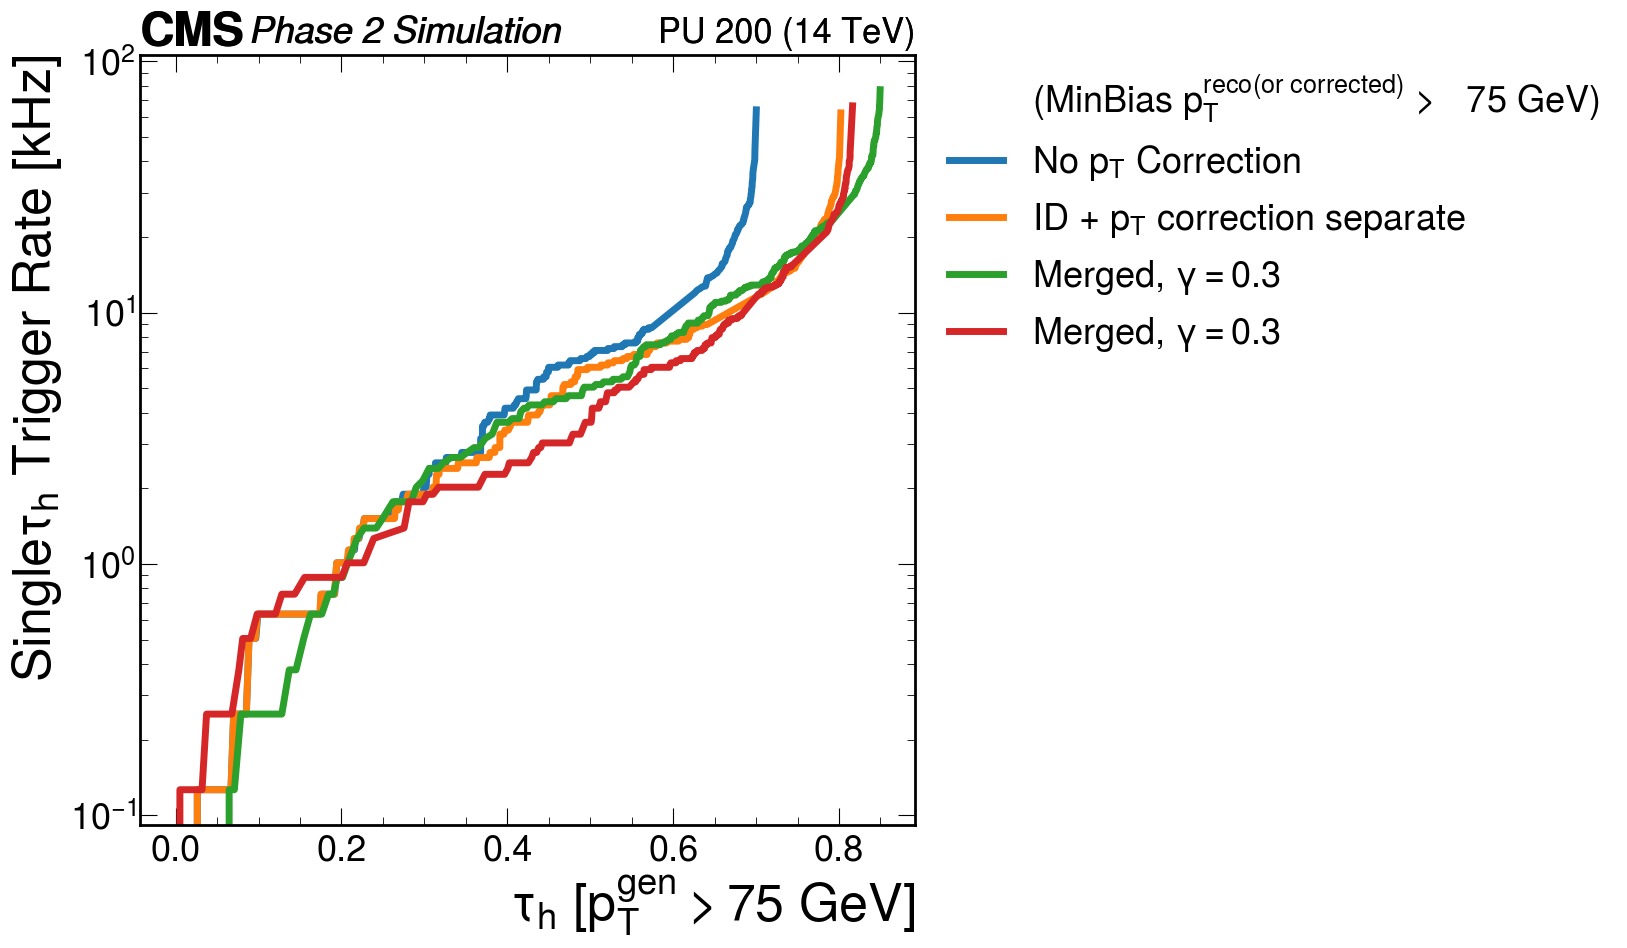

nan


/tmp/ipykernel_1633575/2419662656.py:220: RuntimeWarning: invalid value encountered in double_scalars
  total += bkg_list_scaled_corrected[i] / bkg_list_scaled[i]


In [22]:
# n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
#                                                                                                                                     trained_models,
#                                                                                                                                     truth_sig_pt_cut=75,
#                                                                                                                                     minbias_pt_cut_value=75)

n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    "b",
                                                                                                                                    "b",
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)

### Combined 95% Plot

In [23]:
# def plot_pt_eff_puppi(ModelName,
#                       Model_Regress,
#                       DataPath,
#                       NN = True,
#                       TreeName='ntuplePupSingle',
#                       test_indx=400000,
#                       corrected_pt_cut=1.,
#                       cut_point = 0.21):
#     '''
#     cut_point = 0.21. We accept anything larger than this. 
#     The corresponding corrected pT cut is 30 GeV.

#     dir_path: directory path where the data is saved,
#     '''

#     sig = uproot4.open(DataPath)
#     truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
#     reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

#     #Load model and select out the tau
#     model_id = load_model(ModelName)
#     model_pt_regress = Model_Regress

#     #Get all the inputs
#     sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

#     reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
#     deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
#     eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]
    
#     selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    
#     if NN: #if the flag for using pT correction or is True, correct for pT into corrected_pt_sig
#         ratio_predict = model_pt_regress.predict(np.asarray(sig_input)).flatten()
#         corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)
#         selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
#         #Originally (reco_pt_sig>1.) 
#     else: #else, simply use reco_pt_sig
#         selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
        
#     #Selected out the tau pt with the basic cuts first
#     truth_tau_pt_select = truth_tau_pt[selection_num]

#     X_sig = np.asarray(sig_input[selection_num])
#     y_sig = model_id.predict(np.nan_to_num(X_sig))

#     nn_cut = y_sig.flatten() > cut_point
#     tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

#     #Fill two plots and divide the two.
#     pT_egdes = np.linspace(0, 150, 100) #200?
#     pT_egdes = list(pT_egdes)
#     pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

#     hist_all_tau = Hist(pT_axis)
#     hist_selected_puppi = Hist(pT_axis)
#     hist_selected_tau = Hist(pT_axis)

#     hist_all_tau.fill(truth_tau_pt[selection_deno])
#     hist_selected_puppi.fill(truth_tau_pt_select)
#     hist_selected_tau.fill(tau_pt_nn)

#     %matplotlib inline
#     fig = plt.figure(figsize=(10, 12))
#     _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
#         hist_all_tau,
#         rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
#         rp_denom_label=r"All Taus",
#         rp_uncert_draw_type="bar",
#         rp_uncertainty_type="efficiency",
#     )


#     fig = plt.figure(figsize=(10, 12))
#     _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
#         hist_all_tau,
#         rp_num_label=r"Selected Taus (PUPPI)",
#         rp_denom_label=r"All Taus",
#         rp_uncert_draw_type="bar",
#         rp_uncertainty_type="efficiency",
#     )


#     #The real efficiency plot
#     fig = plt.figure()

#     eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
#     eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
#     eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

#     eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
#     eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
#     eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
#     plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
#     plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
#                 fmt='o',
#                 linewidth=2,
#                 label = 'Retrained Tau NN (> {})'.format(cut_point))

#     plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
#                 fmt='o',
#                 linewidth=2,
#                 label = 'PUPPI')

#     plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
#     plt.ylim([0.,1.1])
#     plt.xlim([0,150])
#     hep.cms.text("Phase 2 Simulation")
#     hep.cms.lumitext("PU 200 (14 TeV)")
#     plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
#     plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
#     plt.legend(loc = 'center right')
#     plt.show()
#     return (eff_new_nn_x, eff_new_nn_y)

# def plot_pt_eff_puppi_merge(ModelName,
#                       Model_Regress,
#                       DataPath,
#                       TreeName='ntuplePupSingle',
#                       test_indx=400000,
#                       corrected_pt_cut=1.,
#                       cut_point = 0.21):
#     '''
#     cut_point = 0.21. We accept anything larger than this. 
#     The corresponding corrected pT cut is 30 GeV.

#     dir_path: directory path where the data is saved,
#     '''

#     sig = uproot4.open(DataPath)
#     truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
#     reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

#     #Load model and select out the tau
#     model_id = load_model(ModelName)
#     model_pt_regress = load_model(Model_Regress)

#     #Get all the inputs
#     sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

#     reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
#     deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
#     eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

#     ratio_predict = model_pt_regress.predict(np.asarray(sig_input))[1].flatten()
#     corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

#     selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
#     selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
#     #Originally (reco_pt_sig>1.) 

#     #Selected out the tau pt with the basic cuts first
#     truth_tau_pt_select = truth_tau_pt[selection_num]

#     X_sig = np.asarray(sig_input[selection_num])
#     y_sig = model_id.predict(np.nan_to_num(X_sig))[0]

#     nn_cut = y_sig.flatten() > cut_point
#     tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

#     #Fill two plots and divide the two.
#     pT_egdes = np.linspace(0, 150, 100) #200?
#     pT_egdes = list(pT_egdes)
#     pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

#     hist_all_tau = Hist(pT_axis)
#     hist_selected_puppi = Hist(pT_axis)
#     hist_selected_tau = Hist(pT_axis)

#     hist_all_tau.fill(truth_tau_pt[selection_deno])
#     hist_selected_puppi.fill(truth_tau_pt_select)
#     hist_selected_tau.fill(tau_pt_nn)

#     %matplotlib inline
#     fig = plt.figure(figsize=(10, 12))
#     _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
#         hist_all_tau,
#         rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
#         rp_denom_label=r"All Taus",
#         rp_uncert_draw_type="bar",
#         rp_uncertainty_type="efficiency",
#     )


#     fig = plt.figure(figsize=(10, 12))
#     _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
#         hist_all_tau,
#         rp_num_label=r"Selected Taus (PUPPI)",
#         rp_denom_label=r"All Taus",
#         rp_uncert_draw_type="bar",
#         rp_uncertainty_type="efficiency",
#     )


#     #The real efficiency plot
#     fig = plt.figure()

#     eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
#     eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
#     eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

#     eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
#     eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
#     eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
#     plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
#     plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
#                 fmt='o',
#                 linewidth=2,
#                 label = 'Retrained Tau NN (> {})'.format(cut_point))

#     plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
#                 fmt='o',
#                 linewidth=2,
#                 label = 'PUPPI')

#     plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
#     plt.ylim([0.,1.1])
#     plt.xlim([0,150])
#     hep.cms.text("Phase 2 Simulation")
#     hep.cms.lumitext("PU 200 (14 TeV)")
#     plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
#     plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
#     plt.legend(loc = 'center right')
#     plt.show()
#     return (eff_new_nn_x, eff_new_nn_y)


In [24]:
# def plot_95th(threshold_list, model_id_name, model_pT, DataPath, cut_point = 0.21):
    
#     threshold_list = threshold_list

#     # pT NN correction
    
#     results = plot_pt_eff_puppi(model_id_name,
#                                 model_pT,
#                                 DataPath,
#                                 NN = True,
#                                 corrected_pt_cut=0,
#                                 cut_point = cut_point)
#     no_cut_x = np.asarray(results[0])
#     no_cut_y = np.asarray(results[1])


#     gen_pT_list = []
#     for i in threshold_list:
#         result = plot_pt_eff_puppi(model_id_name,
#                                 model_pT,
#                                 DataPath,
#                                 NN = True,
#                                 corrected_pt_cut=i,
#                                 cut_point = cut_point)
#         cut_x = np.asarray(result[0])
#         cut_y = np.asarray(result[1])
#         y_norm = np.divide(cut_y, no_cut_y)
#         for i in range(10):
#             if y_norm[i] == 1:
#                 y_norm[i] = 0
#             else:
#                 break
#         gen_pT_list.append(cut_x[y_norm > 0.95][0])
#     gen_pT_list_nn = gen_pT_list
    
#     # no pT NN correction
    
#     results = plot_pt_eff_puppi(model_id_name,
#                                 model_pT,
#                             DataPath,
#                             NN = False,
#                             corrected_pt_cut=0,
#                             cut_point = cut_point)
#     no_cut_x = np.asarray(results[0])
#     no_cut_y = np.asarray(results[1])


#     gen_pT_list = []
#     for i in threshold_list:
#         result = plot_pt_eff_puppi(model_id_name,
#                                 model_pT,
#                                 DataPath,
#                                 NN = False,
#                                 corrected_pt_cut=i,
#                                 cut_point = cut_point)
#         cut_x = np.asarray(result[0])
#         cut_y = np.asarray(result[1])
#         y_norm = np.divide(cut_y, no_cut_y)
#         for i in range(10):
#             if y_norm[i] == 1:
#                 y_norm[i] = 0
#             else:
#                 break
#         gen_pT_list.append(cut_x[y_norm > 0.95][0])
#     gen_pT_list_no_nn = gen_pT_list
    
#     # merged
#     model_name = '../models/merged_11_gamma33.h5'
    
#     results = plot_pt_eff_puppi_merge(model_name,
#                             model_name,
#                             '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
#                             corrected_pt_cut=0,
#                             cut_point = 0.21)
#     no_cut_x = np.asarray(results[0])
#     no_cut_y = np.asarray(results[1])


#     threshold_list = [15, 20, 25,30,35,40,50,60,70,80]
#     gen_pT_list = []
#     for i in threshold_list:
#         result = plot_pt_eff_puppi_merge(model_name,
#                                 model_name,
#                                 '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
#                                 corrected_pt_cut=i,
#                                 cut_point = 0.21)
#         cut_x = np.asarray(result[0])
#         cut_y = np.asarray(result[1])
#         y_norm = np.divide(cut_y, no_cut_y)
#         print(y_norm)
#         for i in range(10):
#             if y_norm[i] == 1:
#                 y_norm[i] = 0
#             else:
#                 break
#         gen_pT_list.append(cut_x[y_norm > 0.95][0])
#     #gen_pT_list = [cut(i) for i in threshold_list]
#     gen_pT_list_nn_merge = gen_pT_list
    
#     # Plotting final plot
    
#     a, b = np.polyfit(threshold_list, gen_pT_list_nn, 1)
#     c, d = np.polyfit(threshold_list, gen_pT_list_no_nn, 1)
#     e, f = np.polyfit(threshold_list, gen_pT_list_nn_merge, 1)
#     fig = plt.figure()
#     plt.plot(threshold_list, [a*i + b for i in threshold_list], "--", linewidth = 1)
#     plt.plot(threshold_list, gen_pT_list_nn, "o-", fillstyle='none', linewidth = 1, label = "NN Corrected pT (y = " + str(round(a, 2)) + "x" + " + " + str(round(b, 2)) + ")", color = 'C0')
#     plt.plot(threshold_list, [c*i + d for i in threshold_list], "--", linewidth = 1, color = 'r')
#     plt.plot(threshold_list, gen_pT_list_no_nn, "o-", fillstyle='none', linewidth = 1, label = "PUPPI Reco pT (y = " + str(round(c, 2)) + "x" + " + " + str(round(d, 2)) + ")", color = 'r')
#     plt.plot(threshold_list, [e*i + f for i in threshold_list], "--", linewidth = 1, color = 'g')
#     plt.plot(threshold_list, gen_pT_list_nn_merge, "o-", fillstyle='none', linewidth = 1, label = "Merged (y = " + str(round(e, 2)) + "x" + " + " + str(round(f, 2)) + ")", color = 'g')
#     #plt.xlim([20,85])
#     #plt.xlim([20,85])
#     #plt.xlim([20,85])
#     hep.cms.text("Phase 2 Simulation")
#     hep.cms.lumitext("PU 200 (14 TeV)")
#     plt.xlabel(r"$p_T$ Cut Threshold [GeV]", fontsize = 25)
#     plt.ylabel(r"$95\%$ Efficiency Point [GeV]", fontsize = 25)
#     plt.legend(loc = 'upper left', fontsize = 18.5)
#     #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#     plt.show()


In [25]:
# model = load_model("../models/pt_regress_v1_bestest.h5")
# plot_95th([15, 20, 25,30,35,40,50,60,70,80], model_id_name,
#                                model, '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root')

In [26]:
# def bob(dir_path, ModelName, test_index=400000):
    
#     #Might have to change the version for other ntuple files
#     data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
#     truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
#     reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
#     deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
#     eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

#     selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
#     truth_pt_selected = np.asarray(truth_pt[selection])
#     reco_pt_selected = np.asarray(reco_pt[selection])
#     X_test = np.asarray(inputs[selection])
    
#     if ModelName == "../models/merged_quantized.h5":
#         model = load_qmodel(ModelName)
#         y_pred = model.predict(X_test)[1].flatten()
#     else:
#         model = load_model(ModelName)
#         if ModelName == '../models/merged_11_gamma33.h5':
#             y_pred = model.predict(X_test)[1].flatten()
#         elif ModelName == "../models/pt_regress_v1_bestest.h5":
#             y_pred = model.predict(X_test).flatten()
    
#     pred_pt = np.multiply(reco_pt_selected, y_pred)
    
#     residual = pred_pt - truth_pt_selected
#     print(min(residual))
#     print(max(residual))
#     plot_bins = 200
#     plot_range = (-125, 75)
#     p_guess=[10, 0, 0.01]
#     plt.hist(residual,
#          bins = plot_bins,
#          range = plot_range,
#          alpha = 0.5,
#          density = True)
#     def fit_function(x, A, mu, sig):
#         return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

#     bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
#     binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
#     data_entries, bin_edges = np.histogram(residual, bins=bins,
#                                    range = plot_range,
#                                    density = True)
#     mask = data_entries!=0
#     #Fit the function to the histogram data.
#     popt, pcov = curve_fit(fit_function,
#                            xdata=binscenters[mask],
#                            ydata=data_entries[mask],
#                            sigma = np.sqrt(data_entries[mask]),
#                            absolute_sigma = False)
    
#     #Error for parameter estimations
#     perr = np.sqrt(np.diag(pcov))
#     print("Error for parameter esimations: ", perr)

#     std_fit = np.abs(popt[2])
#     mean_fit = popt[1]
    
#     print("Standard deviation (fit) is", std_fit)
#     print("Mean (fit) is", mean_fit)
    
#     if ModelName == '../models/merged_11_gamma33.h5':
    
#         #Plot fitted gaussian
#         plt.plot(bins,
#                  fit_function(bins, *popt),
#                  "r-",
#                  linewidth=4,
#                  color = "blue",
#                  label='Best fit (merged)')
#     elif ModelName == "../models/pt_regress_v1_bestest.h5":
#         #Plot fitted gaussian
#         plt.plot(bins,
#                  fit_function(bins, *popt),
#                  "r-",
#                  linewidth=4,
#                  color = "orange",
#                  label='Best fit (separate)')
#     elif ModelName == "../models/merged_quantized.h5":
#         plt.plot(bins,
#                  fit_function(bins, *popt),
#                  "r-",
#                  linewidth=4,
#                  color = "yellow",
#                  label='Best fit (quantized)')

#     plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
#     plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
#     plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
#     plt.ylabel('Normalized counts')

#     plt.legend()
#     #plt.show()

    
# def bob_PUPPI(dir_path, test_index=400000):
    
#     #Might have to change the version for other ntuple files
#     data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
#     truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
#     reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
#     deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
#     eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

#     selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
#     truth_pt_selected = np.asarray(truth_pt[selection])
#     reco_pt_selected = np.asarray(reco_pt[selection])
#     X_test = np.asarray(inputs[selection])
    
#     residual = reco_pt_selected - truth_pt_selected
#     print(min(residual))
#     print(max(residual))
#     plot_bins = 200
#     plot_range = (-125, 75)
#     p_guess=[10, 0, 0.01]
#     plt.hist(residual,
#          bins = plot_bins,
#          range = plot_range,
#          alpha = 0.5,
#          density = True)
#     def fit_function(x, A, mu, sig):
#         return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

#     bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
#     binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
#     data_entries, bin_edges = np.histogram(residual, bins=bins,
#                                    range = plot_range,
#                                    density = True)
#     mask = data_entries!=0
#     #Fit the function to the histogram data.
#     popt, pcov = curve_fit(fit_function,
#                            xdata=binscenters[mask],
#                            ydata=data_entries[mask],
#                            sigma = np.sqrt(data_entries[mask]),
#                            absolute_sigma = False)
    
#     #Error for parameter estimations
#     perr = np.sqrt(np.diag(pcov))
#     print("Error for parameter esimations: ", perr)

#     std_fit = np.abs(popt[2])
#     mean_fit = popt[1]
    
#     print("Standard deviation (fit) is", std_fit)
#     print("Mean (fit) is", mean_fit)
    
    
#     #Plot fitted gaussian
#     plt.plot(bins,
#              fit_function(bins, *popt),
#              "r-",
#              linewidth=4,
#              color = "green",
#              label='Best fit (PUPPI)')

#     plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
#     plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
#     plt.xlabel("$p_T^{PUPPI} - p_T^{gen}$ [GeV]", fontsize = 27)
#     plt.ylabel('Normalized counts')

#     plt.legend()
#     plt.show()


In [27]:
# merged_model = load_model('../models/merged_11_gamma33.h5')
# model = load_model("../models/pt_regress_v1_bestest.h5")
# bob("../../ntuples/Jan_25_2023", '../models/merged_11_gamma33.h5')
# bob("../../ntuples/Jan_25_2023", "../models/pt_regress_v1_bestest.h5")
# bob("../../ntuples/Jan_25_2023", "../models/merged_quantized.h5")
# bob_PUPPI("../../ntuples/Jan_25_2023")

In [28]:
# bob_PUPPI("../../ntuples/Jan_25_2023")